In [41]:
%matplotlib inline

import os
from typing import List

import pandas as pd
from webvtt import WebVTT

In [42]:
data_dir = './ted-talks-transcript'
ted_data_file = os.path.join(data_dir, 'ted_metadata_kaggle.csv')
captions_dir = os.path.join(data_dir, 'subtitles')
available_captions = os.listdir(captions_dir)

In [43]:
df = pd.read_csv(ted_data_file)

In [44]:
tags = set()
for t in df['tags']:
    tags.update(eval(t))

In [45]:
# Find videos with transctipt
df_valid = df[df['vidID_youtube'].notnull()][['name', 'vidID_youtube']]

In [46]:
def get_caption_filename(name: str, lang='en', file_format='vtt') -> str:
    filename: str = f'{name}.{lang}.{file_format}'
    path: str = os.path.join(captions_dir, name, filename)
    return path

In [47]:
def get_caption_file(name: str, lang='en', file_format='vtt') -> WebVTT:
    """Searches for caption file with a given name and return VTT instance"""
    path: str = get_caption_filename(name, lang=lang, file_format=file_format);

    if os.path.exists(path):
        return WebVTT().read(path)
    return None

In [48]:
def get_text(caption_file: WebVTT) -> str:
    if caption_file is None:
        return ''
    
    caption_list = map(lambda c: c.text, caption_file.captions)
    
    return ' '.join(caption_list)

In [49]:
def save_text(name: str) -> None:
    caption_file = get_caption_file(name)
    
    if caption_file is None:
        return None
    
    caption_list = map(lambda c: c.text + ' ', caption_file.captions)
    
    filename = caption_file.file.split('.')
    filename[-1] = 'txt'
    filename = '.'.join(filename)
    
    with open(filename, 'w') as f:
        f.writelines(caption_list)

In [50]:
# Check that all documents are stored
df_valid['filename'] = df_valid['vidID_youtube'].apply(get_caption_filename)
df_valid['exists'] = df_valid['filename'].apply(os.path.exists)
df_valid['filename'] = df_valid['vidID_youtube'].apply(get_caption_filename, file_format='txt')
df_valid[df_valid['exists'] == False].count()

name             0
vidID_youtube    0
filename         0
exists           0
dtype: int64

In [35]:
for name in df_valid['vidID_youtube']:
    save_text(name)

In [51]:
from string import punctuation

# Table to translate all punctuation into whitespace
table = str.maketrans({key: ' ' for key in list(punctuation)})

def preprocess(raw_text: str) -> str:
    """Remove all punctuation from the text"""
    raw_text = raw_text.translate(table)
    return raw_text.lower()

In [52]:
from nltk import word_tokenize, pos_tag
from nltk.stem import PorterStemmer, WordNetLemmatizer

lemmatize = True
stemmatize = False

stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def tokenize(raw_text: str) -> List[str]:
    tokens = word_tokenize(raw_text)
    
    if lemmatize:
        return [lemmatizer.lemmatize(w) for w in tokens]
    return [stemmer.stem(w) for w in tokens]

In [20]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

STOP_WORDS = [stemmer.stem(w) for w in stopwords.words('english')] + [
    're go', '—', 'yeah', 'okay', 'ok', 'oh', 'ye', 'bit', 'whole', 'ever', 'bit', 're', 'go', 'c', 'isn', 'per',
    're look', 're talk', 're try', 'really want', 'say go', 'say know', 'say re', 'say well', 'th', '000']


vectorizer = TfidfVectorizer(
    input='filename',
    tokenizer=tokenize, 
    preprocessor=preprocess,
    analyzer='word', 
    stop_words=STOP_WORDS, 
    lowercase=True, 
    ngram_range=(1, 1),
    max_df=0.5,
    min_df=0.1,
)

data = vectorizer.fit_transform(df_valid['filename'])

KeyboardInterrupt: 

In [373]:
import pickle
# Dump data
pickle.dump(data, open('Tf-Idf_data.pickle', 'wb'))
pickle.dump(vectorizer, open('Tf-Idf_vectorizer.pickle', 'wb'))

In [55]:
import pickle
# Load data
data = pickle.load(open('Tf-Idf_data.pickle', 'rb'))
vectorizer = pickle.load(open('Tf-Idf_vectorizer.pickle', 'rb'))

In [56]:
N_clusters = 200
N_components = 100

In [57]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD

if N_components:
    svd = TruncatedSVD(N_components)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)
    data = lsa.fit_transform(data)

In [58]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=N_clusters, tol=1e-5)
model.fit(data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=200, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=1e-05, verbose=0)

In [59]:
def show_clusters(model, vectorizer, svd=None):
    terms = vectorizer.get_feature_names()
    if svd is not None:
        original_space_centroids = svd.inverse_transform(model.cluster_centers_)
        order_centroids = original_space_centroids.argsort()[:, ::-1]
    else:
        order_centroids = model.cluster_centers_.argsort()[:, ::-1]\

    for i in range(model.n_clusters):
        print("Cluster %d:" % (i + 1), end='')
        for ind in order_centroids[i, :10]:
            print(' %s' % terms[ind], end='')
        print()

show_clusters(model, vectorizer, svd)

Cluster 1: brain memory behavior pattern area body child cell activity arm
Cluster 2: image camera technology digital law project video picture object story
Cluster 3: water video music eye body feel language foot moment went
Cluster 4: cell disease technology science body system death million 000 cost
Cluster 5: medium internet social online society woman political group public video
Cluster 6: brain child percent baby social study mind specie face behavior
Cluster 7: home family community kid dream money house living young music
Cluster 8: machine computer technology system design future space game build building
Cluster 9: guy stuff hand kid went job war movie box arm
Cluster 10: music play sound piece playing hear note translator reviewer audience
Cluster 11: went wanted guy car kid job moment feel friend school
Cluster 12: computer sort video child object eye technology looking book camera
Cluster 13: woman men man girl country boy young society story culture
Cluster 14: teacher s

Cluster 164: health care patient hospital doctor system medical data disease technology
Cluster 165: video sound object camera device music tool phone computer physical
Cluster 166: climate earth global sea ocean foot image art planet camera
Cluster 167: word feel experience home love voice man woman friend someone
Cluster 168: computer system program design stuff information guy learning number sort
Cluster 169: body skin arm space technology blood went inside father man
Cluster 170: india china innovation country poor company growth technology education school
Cluster 171: conversation feel rule person woman someone experience love friend always
Cluster 172: girl boy woman daughter school father story music young parent
Cluster 173: future kid climate past decision data social present history percent
Cluster 174: video music camera piece voice google online map black friend
Cluster 175: material structure product water process surface paper energy form stuff
Cluster 176: company busi

In [60]:
from sklearn.metrics import silhouette_score
silhouette_avg = silhouette_score(data, model.labels_)
print("Average Silhouette Coefficient: %0.3f" % silhouette_avg)

Average Silhouette Coefficient: 0.085


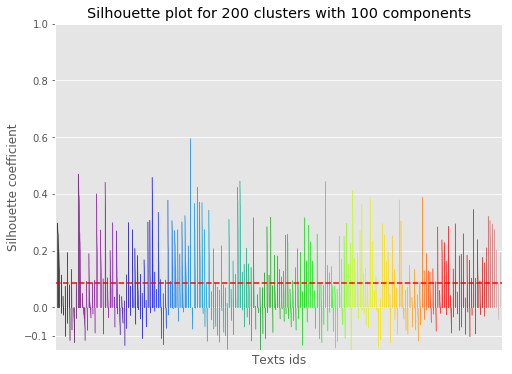

In [62]:
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples

def silhouette_graph(model, data, svd, legend=False, save=False):
    plt.style.use('ggplot')
    fig = plt.figure(N_clusters, figsize=(8, 6))
    ax1 = plt.subplot(111)
    ax1.axis([0, len(model.labels_) + (model.n_clusters + 1) * 25, -0.15, 1])

    sample_silhouette_values = silhouette_samples(data, model.labels_)
    silhouette_avg = silhouette_score(data, model.labels_)

    x_left = 25
    for i in range(model.n_clusters):
        sample = sample_silhouette_values[model.labels_ == i]
        sample.sort()
        sample = sample[::-1]

        cluster_size = sample.shape[0]
        x_right = x_left + cluster_size
        color = cm.nipy_spectral(float(i) / model.n_clusters)

        ax1.fill_between(
            np.arange(x_left, x_right), 0, sample, 
            facecolor=color, edgecolor=color, alpha=0.7, label='{}'.format(i)
        )
        x_left = x_right + 25

    plt.title('Silhouette plot for {} clusters with {} components'.format(model.n_clusters, svd.n_components))
    ax1.set_xlabel("Texts ids")
    ax1.set_ylabel("Silhouette coefficient")
    ax1.axhline(y=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    ax1.set_xticks([])
    
    if legend:
        box = ax1.get_position()
        ax1.set_position([box.x0, box.y0, box.width * 0.9, box.height])
        ax1.legend(loc='center left', fancybox=True, shadow=True, bbox_to_anchor=(1, 0.5), ncol=2)
        
    if save:
        plt.savefig('Silhouette plot for {} clusters.png'.format(model.n_clusters), dpi=1000)
        
    plt.show()

silhouette_graph(model, data, svd)

In [22]:
def silhouette_metric(estimator, X):
    clusters = estimator.fit_predict(X)
    score = silhouette_score(estimator.steps[0][1].transform(X), clusters)
    return score

In [31]:
import pickle

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

with open('Tf-Idf_data.pickle', 'rb') as model_pickle:
    data = pickle.load(model_pickle)

pipe = Pipeline(steps=[
    ('lsa', Pipeline(steps=[
        ('svd', TruncatedSVD()),
        ('norm', Normalizer(copy=False))
    ])),
    ('kmeans', KMeans())
])

parms = {
    'kmeans__n_clusters': range(3, 200),
    'lsa__svd__n_components': range(50, 650, 50)
}

grid = GridSearchCV(pipe, param_grid=parms, scoring=silhouette_metric, verbose=2)
grid.fit(data)

with open('grid.pickle', 'wb') as f:
    pickle.dump(grid, f)

Fitting 3 folds for each of 2364 candidates, totalling 7092 fits
[CV] kmeans__n_clusters=3, lsa__svd__n_components=50 .................
[CV] .. kmeans__n_clusters=3, lsa__svd__n_components=50, total=   0.4s
[CV] kmeans__n_clusters=3, lsa__svd__n_components=50 .................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV] .. kmeans__n_clusters=3, lsa__svd__n_components=50, total=   0.4s
[CV] kmeans__n_clusters=3, lsa__svd__n_components=50 .................
[CV] .. kmeans__n_clusters=3, lsa__svd__n_components=50, total=   0.4s
[CV] kmeans__n_clusters=3, lsa__svd__n_components=100 ................
[CV] . kmeans__n_clusters=3, lsa__svd__n_components=100, total=   0.6s
[CV] kmeans__n_clusters=3, lsa__svd__n_components=100 ................
[CV] . kmeans__n_clusters=3, lsa__svd__n_components=100, total=   0.6s
[CV] kmeans__n_clusters=3, lsa__svd__n_components=100 ................
[CV] . kmeans__n_clusters=3, lsa__svd__n_components=100, total=   0.6s
[CV] kmeans__n_clusters=3, lsa__svd__n_components=150 ................
[CV] . kmeans__n_clusters=3, lsa__svd__n_components=150, total=   0.8s
[CV] kmeans__n_clusters=3, lsa__svd__n_components=150 ................
[CV] . kmeans__n_clusters=3, lsa__svd__n_components=150, total=   0.8s
[CV] kmeans__n_clusters=3, lsa__svd__n_components=150 ................
[CV] .

KeyboardInterrupt: 

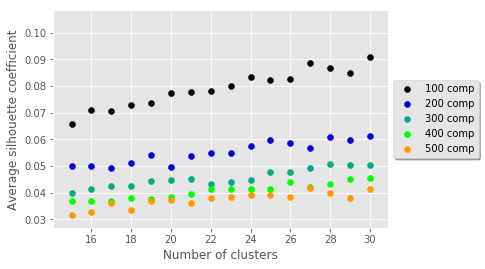

In [435]:
fig = plt.figure(5)
ax = plt.subplot(111)
for i in range(0, 5):
    color = cm.nipy_spectral(float(i) / 5)
    Y = result[:, i]
    ax.scatter(X, Y, c=color, label=f'{(i + 1) * 100} comp')
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Average silhouette coefficient')
ax1.set_position([box.x0, box.y0, box.width * 0.9, box.height])
ax.legend(loc='center left', fancybox=True, shadow=True, bbox_to_anchor=(1, 0.5))
plt.savefig('Nclusters vs nComp vs avg sil.png')
plt.show()

In [25]:
from sklearn.pipeline import Pipeline

with open('Tf-Idf_data.pickle', 'rb') as model_pickle:
    data = pickle.load(model_pickle)
    
pipe = Pipeline(steps=[
    ('lsa', Pipeline(steps=[
        ('svd', TruncatedSVD(100)),
        ('norm', Normalizer(copy=False))
    ])),
    ('kmeans', KMeans())
])

n_clusters_array = np.arange(2, 200)
cluster_result = np.empty_like(n_clusters_array, dtype=float)

for (i, k) in enumerate(n_clusters_array):
    pipe.set_params(**{'kmeans__n_clusters': k})
    labels = pipe.fit_predict(data)      
    cluster_result[i] = silhouette_score(pipe.steps[0][1].transform(data), labels)

KeyboardInterrupt: 

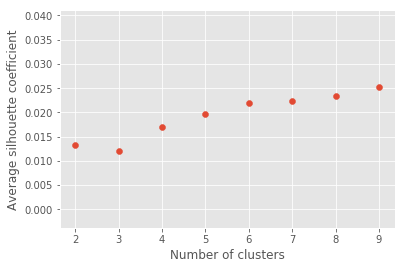

In [57]:
plt.scatter(n_clusters_array, cluster_result)
plt.xlabel('Number of clusters')
plt.ylabel('Average silhouette coefficient')
# plt.savefig('Nclusters vs avg sil.png', dpi=1000)
plt.show()

In [424]:
with open('Tf-Idf_data.pickle', 'rb') as model_pickle:
    data = pickle.load(model_pickle)

pipe = Pipeline(steps=[
    ('lsa', Pipeline(steps=[
        ('svd', TruncatedSVD()),
        ('norm', Normalizer(copy=False))
    ])),
    ('kmeans', KMeans(20))
])

n_comp_array = np.arrange(100, 550, 50)
comp_result = np.empty_like(n_comp_array, dtype=float)

for (i, k) in enumerate(n_comp_array):
    pipe.set_params(**{'truncatedsvd__n_components': k})
    labels = pipe.fit_predict(X)        
    comp_result[i] = silhouette_score(pipe.steps[0][1].transform(X), labels)

Working on 100 components
Working on 150 components
Working on 200 components
Working on 250 components
Working on 300 components
Working on 350 components
Working on 400 components
Working on 450 components
Working on 500 components


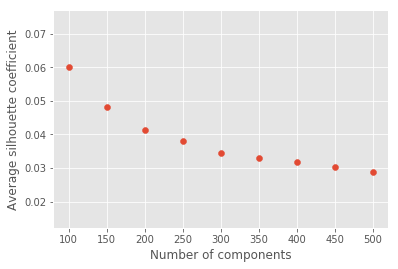

In [429]:
plt.scatter(n_comp_array, comp_result)
plt.xlabel('Number of components')
plt.ylabel('Average silhouette coefficient')
plt.savefig('Ncomponents vs avg sil.png', dpi=1000)
plt.show()